#DATA PROCESS

In [ ]:
import geemap
import ee
import geopandas as gpd
ee.Authenticate()
ee.Initialize(project='ee-bansir')
Map=geemap.Map()
Map.setCenter(72.8311,21.1702,10)
Map

Map(center=[21.1702, 72.8311], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDa…

In [ ]:
import time
import pandas as pd
# Record the start time
start_time = time.time()

result_df = pd.DataFrame(columns=['year', 'quarter', 'class', 'total_area', 'class_area', 'percentage'])
Years = list(range(2019, 2024))  # Adding years from 2019 to 2023
Quarters = [(1, 3), (4, 6), (7, 9), (10, 12)]  # Define quarters as tuples of start and end months
shapefile = ee.FeatureCollection("projects/ee-bansir/assets/surat-zone-boundary")

def maskS2clouds(image):
    qa = image.select('QA60')

    # Bits 10 and 11 are clouds and cirrus, respectively.
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11

    # Both flags should be set to zero, indicating clear conditions.
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(
        qa.bitwiseAnd(cirrusBitMask).eq(0))

    # Return the masked and scaled data, without the QA bands.
    return image.updateMask(mask).divide(10000) \
        .select("B.*") \
        .copyProperties(image, ["system:time_start"])

for y in Years:  # Iterating over the years
    for quarter_num, (start_month, end_month) in enumerate(Quarters, start=1):
        selectedRegion = shapefile.geometry()
        collection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
            .filterDate(str(y)+'-'+str(start_month).zfill(2)+'-01', str(y)+'-'+str(end_month).zfill(2)+'-28') \
            .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
            .map(maskS2clouds)

        def calculateEVI(image):
            evi = image.expression(
                '2.5 * ((B8 - B4) / (B8 + 6 * B4 - 7.5 * B2 + 1))', {
                    'B8': image.select('B8'),  # Near-Infrared
                    'B4': image.select('B4'),  # Red
                    'B2': image.select('B2')   # Blue
                }).rename('EVI')
            return image.addBands([evi])

        def calculateNDBI(image):
            ndbi = image.expression(
                '(SWIR1 - NIR) / (SWIR1 + NIR)', {
                    'SWIR1': image.select('B11'),  # Shortwave Infrared 1
                    'NIR': image.select('B8'),     # Near-Infrared
                }).rename('NDBI')
            return image.addBands([ndbi])

        def calculateNDBaI(image):
            ndbai = image.expression(
                '(SWIR1 - SWIR2) / (SWIR1 + SWIR2)', {
                    'SWIR1': image.select('B11'),  # Shortwave Infrared 1
                    'SWIR2': image.select('B12')   # Shortwave Infrared 2
                }).rename('NDBaI')
            return image.addBands([ndbai])

        collection_for_all = collection.map(calculateEVI).map(calculateNDBI).map(calculateNDBaI)
        composite_for_all = collection_for_all.median()
        im = composite_for_all.clip(selectedRegion)
        water = im.select('EVI').lt(0)
        land = water.eq(0)
        builtup = land.And(im.select('NDBI').gt(-0.2)).And(im.select('NDBaI').lte(0.2)).subtract((im.select('EVI').gte(0.2)).And(im.select('EVI').lte(0.39)))
        high_vegetation = land.And(im.select('EVI').gte(0.5))
        m_vegetation = land.And(im.select('EVI').gte(0.4)).And(im.select('EVI').lt(0.5))
        mild_vegetation = land.And(im.select('EVI').gte(0.3)).And(im.select('EVI').lte(0.39))
        light_vegetation = land.And(im.select('EVI').gte(0.2)).And(im.select('EVI').lte(0.29))

        classes = {'water': water, 'land': land, 'builtup': builtup, 'high_vegetation': high_vegetation,
                   'm_vegetation': m_vegetation, 'mild_vegetation': mild_vegetation, 'light_vegetation': light_vegetation}

        for class_name, class_mask in classes.items():
            area_pixel = ee.Image.pixelArea().divide(10000)
            area = ee.Number(im.mask().multiply(area_pixel).reduceRegion(
                reducer=ee.Reducer.sum(),
                geometry=selectedRegion,
                scale=10,
                bestEffort=True
            ).get('EVI'))

            class_area = ee.Number(class_mask.multiply(area_pixel).reduceRegion(
                reducer=ee.Reducer.sum(),
                geometry=selectedRegion,
                scale=10,
                bestEffort=True
            ).get('EVI'))

            percentage = (class_area.getInfo() / area.getInfo()) * 100 if area.getInfo() != 0 else 0

            result_df = result_df.append({
                'year': y,
                'quarter': quarter_num,
                'class': class_name,
                'total_area': area.getInfo(),
                'class_area': class_area.getInfo(),
                'percentage': percentage
            }, ignore_index=True)

# Print the resulting DataFrame
print(result_df)
end_time = time.time()

# Calculate the runtime duration
runtime_duration_seconds = end_time - start_time

# Convert seconds to hours, minutes, and seconds
hours = int(runtime_duration_seconds // 3600)
minutes = int((runtime_duration_seconds % 3600) // 60)
seconds = int(runtime_duration_seconds % 60)

print(f"Runtime duration: {hours} hours, {minutes} minutes, {seconds} seconds")

result_df.to_csv('Surat_2019_to_2023.csv')

     year quarter             class    total_area    class_area  percentage
0    2019       1             water  46063.675028    478.082322    1.037873
1    2019       1              land  46063.675028  45666.632151   99.138056
2    2019       1           builtup  46063.675028  29266.082488   63.533972
3    2019       1   high_vegetation  46063.675028    388.731010    0.843899
4    2019       1      m_vegetation  46063.675028    954.475124    2.072078
..    ...     ...               ...           ...           ...         ...
135  2023       4           builtup  46063.675028  10874.258440   23.607014
136  2023       4   high_vegetation  46063.675028   1653.552448    3.589710
137  2023       4      m_vegetation  46063.675028   4477.596656    9.720450
138  2023       4   mild_vegetation  46063.675028   7113.640939   15.443060
139  2023       4  light_vegetation  46063.675028   7763.776046   16.854443

[140 rows x 6 columns]
Runtime duration: 1 hours, 6 minutes, 23 seconds


In [ ]:
import pandas as pd
df = pd.read_csv('/content/Surat_2019_to_2023.csv')

df['class_area'] = df['class_area'].replace(0, float('NaN'))

# Get unique combinations of year and class
unique_combinations = df[['year', 'class']].drop_duplicates()

# Iterate over each unique combination
for index, row in unique_combinations.iterrows():
    year = row['year']
    _class = row['class']

    # Filter the DataFrame for the specific year, quarter, and class
    filtered_data = df[(df['year']==year)  & (df['class']==_class)]

    # Calculate the mean value for quarters 1, 2, and 4
    mean_value_q1_q2_q4 = filtered_data.loc[filtered_data['quarter'].isin([1, 2, 4]), 'class_area'].mean()

    # Update the NaN value in quarter 3 with the calculated mean
    df.loc[(df['year']==year)  & (df['class']==_class) & (df['quarter']==3), 'class_area'] = mean_value_q1_q2_q4

# Check if there are any remaining missing values
print(df[df['class_area'].isnull()])

df.to_csv('surat_2019_2023.csv')


Empty DataFrame
Columns: [Unnamed: 0, year, quarter, class, total_area, class_area, percentage]
Index: []


#WEIGHTED MEAN

---



In [ ]:
import pandas as pd

# Load the DataFrame
df = pd.read_csv('/content/Surat_2019_to_2023.csv')

# Replace 0 with NaN in the 'class_area' column
df['class_area'] = df['class_area'].replace(0, float('NaN'))

# Get unique combinations of year and class
unique_combinations = df[['year', 'class']].drop_duplicates()

# Iterate over each unique combination
for index, row in unique_combinations.iterrows():
    year = row['year']
    _class = row['class']

    # Filter the DataFrame for the specific year, quarter, and class
    filtered_data = df[(df['year']==year)  & (df['class']==_class)]

    # Calculate the weighted mean value for quarters 1, 2, and 4
    weighted_mean_q1_q2_q4 = (filtered_data.loc[filtered_data['quarter'].isin([1, 2, 4]), 'class_area'] *
                               filtered_data.loc[filtered_data['quarter'].isin([1, 2, 4]), 'quarter'].map({1: 0.2, 2: 0.2, 4: 0.6})).sum() / \
                              filtered_data.loc[filtered_data['quarter'].isin([1, 2, 4]), 'quarter'].map({1: 0.2, 2: 0.2, 4: 0.6}).sum()

    # Update the NaN value in quarter 3 with the calculated weighted mean
    df.loc[(df['year']==year)  & (df['class']==_class) & (df['quarter']==3), 'class_area'] = weighted_mean_q1_q2_q4

# Check if there are any remaining missing values
print(df[df['class_area'].isnull()])

# Save the DataFrame to a new CSV file
df.to_csv('surat_2019_2023.csv', index=False)

Empty DataFrame
Columns: [Unnamed: 0, year, quarter, class, total_area, class_area, percentage]
Index: []


# EXPONENTIATION MOVING AVERAGE

In [ ]:
# Load the DataFrame
df = pd.read_csv('/content/surat_2019_2023.csv')

# Concatenate 'year' and 'quarter' columns into a new column
df['year_quarter'] = df['year'].astype(str) + ' Q' + df['quarter'].astype(str)

# Get unique classes excluding 'land'
unique_classes = df[df['class'] != 'land']['class'].unique()

# Initialize an empty DataFrame to store EMA values
ema_df = pd.DataFrame()

# Set span value
span_value = 1

# Set up the plot for each class
for _class in unique_classes:
    # Filter the data for the specific class
    df_class = df[df['class'] == _class]  # Use the current class

    # Group by year_quarter and calculate the mean class area for each year_quarter
    class_area_by_year_quarter = df_class.groupby('year_quarter')['class_area'].mean()

    # Calculate Exponential Moving Average (EMA) with the current span value
    ema = class_area_by_year_quarter.ewm(span=span_value, adjust=False).mean()

    # Concatenate EMA values to the DataFrame
    ema_df[_class] = ema

    # Concatenate original data as well
    ema_df[f"{_class}_original"] = class_area_by_year_quarter

# Display the DataFrame
print(ema_df)

# Save the DataFrame to a CSV file
ema_df.to_csv('ema_data_surat.csv', index=True)


                   builtup  builtup_original  high_vegetation  \
year_quarter                                                    
2019 Q1       29266.277350      29266.277350       388.731010   
2019 Q2       31798.057000      31798.057000       776.506200   
2019 Q3       18871.917450      18871.917450      1014.923577   
2019 Q4       11098.417630      11098.417630      1303.126891   
2020 Q1       23003.283720      23003.283720       413.260727   
2020 Q2       27254.247730      27254.247730      1274.055182   
2020 Q3       17490.971170      17490.971170       812.936715   
2020 Q4       12399.108130      12399.108130       792.455888   
2021 Q1       23830.919780      23830.919780       335.893838   
2021 Q2       27857.141360      27857.141360       591.115072   
2021 Q3       16139.029520      16139.029520       822.727626   
2021 Q4        9669.028823       9669.028823      1062.209739   
2022 Q1       23543.803940      23543.803940       297.241660   
2022 Q2       27338.94172

# SPAN WISE elasticity

In [ ]:
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

single elasticity

In [ ]:
import pandas as pd
import numpy as np

# Load the DataFrame
df = pd.read_excel('/content/111111.xlsx')

# Function to calculate elasticity
def calculate_elasticity(x, y):
    return np.divide(x, y, out=np.zeros_like(x), where=y!=0)

# Initialize a dictionary to store elasticity values for each class
elasticity_data = {class_name: [] for class_name in ['high', 'moderate', 'mild', 'light']}

# Calculate elasticity for each class and each year
for class_name in elasticity_data.keys():
    elasticity_values = []
    for i in range(1, len(df)):  # Start from the second row
        builtup_change = (df['builtup'][i] - df['builtup'][i-1]) / df['builtup'][i-1] * 100
        other_class_change = (df[class_name][i] - df[class_name][i-1]) / df[class_name][i-1] * 100
        elasticity = calculate_elasticity(builtup_change, other_class_change)
        elasticity = np.clip(elasticity, -1, 1)  # Ensure elasticity values are within range [-1, 1]
        elasticity_values.append(elasticity)
    elasticity_data[class_name] = elasticity_values

# Aggregate elasticity for all years together
aggregated_elasticity = {}
for class_name, elasticity_values in elasticity_data.items():
    aggregated_elasticity[class_name] = np.mean(elasticity_values)

# Print aggregated elasticity
for class_name, elasticity in aggregated_elasticity.items():
    print(f'{class_name}: {elasticity}')

# Save aggregated elasticity to a CSV file
aggregated_elasticity_df = pd.DataFrame(aggregated_elasticity.items(), columns=['Class', 'Elasticity'])
aggregated_elasticity_df.to_csv('aggregated_elasticity.csv', index=False)



high: -0.06102105154193338
moderate: -0.3120234807957818
mild: -0.5249103417156202
light: -0.05633883508305336


group wise

In [ ]:
import pandas as pd
import numpy as np

# Load data from the provided Excel file
df = pd.read_excel('/content/111111.xlsx')

# Define combinations of classes
class_combinations = [('high', 'mild'), ('high', 'moderate'), ('high', 'light'), ('light', 'mild'), ('light', 'moderate'), ('moderate', 'mild')]

# Initialize a dictionary to store elasticity values for each class combination
combination_elasticity_data = {combo: [] for combo in class_combinations}

# Function to calculate elasticity
def calculate_elasticity(x, y):
    return np.divide(x, y, out=np.zeros_like(x), where=y!=0)

# Calculate elasticity for each class combination and each year
for combo in class_combinations:
    combo_elasticity_values = []
    for i in range(1, len(df)):  # Start from the second row
        builtup_change = (df['builtup'].iloc[i] - df['builtup'].iloc[i-1]) / df['builtup'].iloc[i-1] * 100
        class1_change = (df[combo[0]].iloc[i] - df[combo[0]].iloc[i-1]) / df[combo[0]].iloc[i-1] * 100
        class2_change = (df[combo[1]].iloc[i] - df[combo[1]].iloc[i-1]) / df[combo[1]].iloc[i-1] * 100
        elasticity1 = calculate_elasticity(builtup_change, class1_change)
        elasticity2 = calculate_elasticity(builtup_change, class2_change)
        elasticity = (elasticity1 + elasticity2) / 2  # Average elasticity of both classes
        elasticity = np.clip(elasticity, -1, 1)  # Ensure elasticity values are within range [-1, 1]
        combo_elasticity_values.append(elasticity)
    combination_elasticity_data[combo] = combo_elasticity_values

# Aggregate elasticity for all years together for each class combination
aggregated_combination_elasticity = {}
for combo, elasticity_values in combination_elasticity_data.items():
    aggregated_combination_elasticity[combo] = np.mean(elasticity_values)

# Convert aggregated elasticity data to a DataFrame
elasticity_df = pd.DataFrame(list(aggregated_combination_elasticity.items()), columns=['Class Combination', 'Aggregated Elasticity'])

# Save DataFrame to CSV file
elasticity_df.to_csv('elasticity_data.csv', index=False)


Three combined vegetation group

In [ ]:
import pandas as pd
import numpy as np

# Load data from the provided Excel file
df = pd.read_excel('/content/111111.xlsx')

# Define groups of classes
groups = {
    'high+mild+moderate': ['high', 'mild', 'moderate'],
    'high+moderate+light': ['high', 'moderate', 'light'],
    'high+light+mild': ['high', 'light', 'mild'],
    'light+mild+moderate': ['light', 'mild', 'moderate']
}

# Initialize a dictionary to store elasticity values for each class
elasticity_data = {class_name: [] for class_name in df.columns[1:]}

# Function to calculate elasticity
def calculate_elasticity(x, y):
    return np.divide(x, y, out=np.zeros_like(x), where=y!=0)

# Calculate elasticity for each class and each year
for class_name in elasticity_data.keys():
    elasticity_values = []
    for i in range(1, len(df)):  # Start from the second row
        builtup_change = (df['builtup'].iloc[i] - df['builtup'].iloc[i-1]) / df['builtup'].iloc[i-1] * 100
        class_change = (df[class_name].iloc[i] - df[class_name].iloc[i-1]) / df[class_name].iloc[i-1] * 100
        elasticity = calculate_elasticity(builtup_change, class_change)
        elasticity = np.clip(elasticity, -1, 1)  # Ensure elasticity values are within range [-1, 1]
        elasticity_values.append(elasticity)
    elasticity_data[class_name] = elasticity_values

# Aggregate elasticity for each group
group_aggregated_elasticity = {}
for group_name, group_classes in groups.items():
    group_elasticity_values = []
    for class_name in group_classes:
        group_elasticity_values.extend(elasticity_data[class_name])
    group_aggregated_elasticity[group_name] = np.mean(group_elasticity_values)

# Convert dictionary to DataFrame
group_df = pd.DataFrame(group_aggregated_elasticity.items(), columns=['Group', 'Aggregated_Elasticity'])

# Save DataFrame to CSV
group_df.to_csv('group_aggregated_elasticity.csv', index=False)

# Print aggregated elasticity for each group
for group_name, elasticity in group_aggregated_elasticity.items():
    print(f"Elasticity for {group_name}: {elasticity}")


Elasticity for high+mild+moderate: -0.2993182913511118
Elasticity for high+moderate+light: -0.14312778914025617
Elasticity for high+light+mild: -0.21409007611353564
Elasticity for light+mild+moderate: -0.29775755253148517


Total vegetation

In [ ]:
import pandas as pd
import numpy as np

# Load data from the Excel file
df = pd.read_excel('/content/111111.xlsx')

# Define the classes to consider
classes_to_consider = ['high', 'mild', 'moderate', 'light']

# Function to calculate elasticity
def calculate_elasticity(x, y):
    return np.divide(x, y, out=np.zeros_like(x), where=y!=0)

# Initialize a dictionary to store elasticity values for each class
elasticity_data = {class_name: [] for class_name in classes_to_consider}

# Calculate elasticity for each class and each year
for class_name in classes_to_consider:
    elasticity_values = []
    for i in range(1, len(df)):  # Start from the second row
        builtup_change = (df['builtup'].iloc[i] - df['builtup'].iloc[i-1]) / df['builtup'].iloc[i-1] * 100
        class_change = (df[class_name].iloc[i] - df[class_name].iloc[i-1]) / df[class_name].iloc[i-1] * 100
        elasticity = calculate_elasticity(builtup_change, class_change)
        elasticity = np.clip(elasticity, -1, 1)  # Ensure elasticity values are within range [-1, 1]
        elasticity_values.append(elasticity)
    elasticity_data[class_name] = elasticity_values

# Aggregate elasticity for the combination of all classes
aggregated_elasticity_all = []
for i in range(len(df) - 1):  # -1 because we're calculating change from previous year
    combined_elasticity = np.mean([elasticity_data[class_name][i] for class_name in classes_to_consider])
    aggregated_elasticity_all.append(combined_elasticity)

# Calculate the average aggregated elasticity for all years
average_aggregated_elasticity_all = np.mean(aggregated_elasticity_all)

# Save the average aggregated elasticity to a CSV file
with open("aggregated_elasticity_all.csv", mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Average Aggregated Elasticity for all classes", average_aggregated_elasticity_all])

print(f"CSV file saved successfully with the average aggregated elasticity: {average_aggregated_elasticity_all}")



CSV file saved successfully with the average aggregated elasticity: -0.23857342728409717


# Ratio

In [ ]:
import pandas as pd

# Read data from file
data_file_path = '/content/ema_data_surat_WM.csv'  # Replace 'your_data_file.csv' with the path to your data file
df = pd.read_csv(data_file_path)

# Define a function to calculate the ratio
def calculate_ratio(column):
    ratio_values = []
    for i in range(0, len(column), 4):
        avg_value = column[i:i+4].mean()
        ratio_values.append(avg_value)
    return ratio_values

# Iterate over each column (except the first one)
ratios = {}
for col in df.columns[1:]:
    ratios[col] = calculate_ratio(df[col])

# Convert the dictionary into a DataFrame
df1 = pd.DataFrame(ratios)

# Show the resulting DataFrame
print(df1)


   builtup_span1   high_span1      m_span1   mild_span1  light_span1
0   22758.667357   870.821920  2279.280221  4800.168096  6754.105473
1   20036.902687   823.177128  2282.470075  5040.258289  7879.212735
2   19374.029871   702.986569  2420.583988  5372.737061  7886.279025
3   20428.565817   808.662122  2164.459805  4710.675478  8028.163650
4   19527.860608  1227.035798  2893.522367  4923.169104  7077.837012


In [ ]:
ratios = (((df1['high_span1'] + df1['m_span1'] + df1['mild_span1'] + df1['light_span1'])/4) / df1['builtup_span1']) * 100

# Print the resulting ratios DataFrame
print(ratios)

file_path = "ratio_data_WM_Surat.csv"

# Save the DataFrame to a CSV file
ratios.to_csv(file_path, index=False)

0    16.152501
1    19.994505
2    21.139880
3    19.227930
4    20.639184
dtype: float64


heatmap

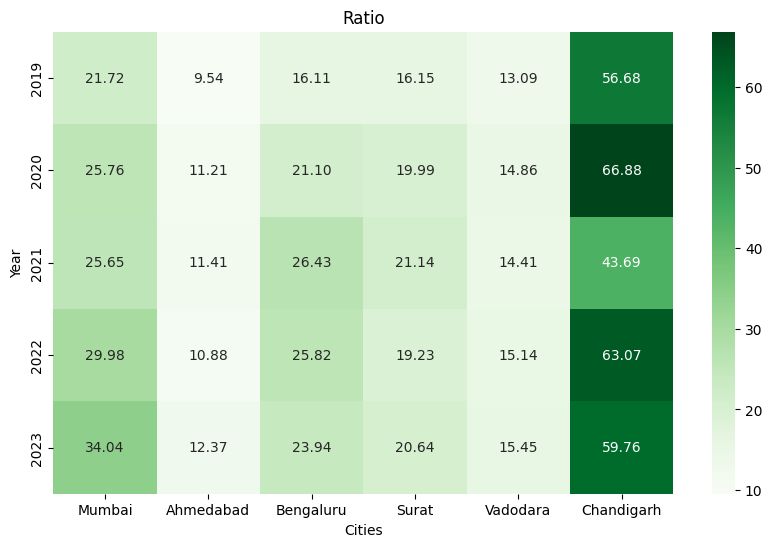

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read CSV file
df = pd.read_csv("/content/Ratio.csv")

# Remove leading or trailing whitespaces from column names
df.columns = df.columns.str.strip()

# Set the 'Year' column as index
df.set_index('Year', inplace=True)

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df, annot=True, cmap='Greens', fmt=".2f")
plt.title('Ratio')
plt.xlabel('Cities')
plt.ylabel('Year')
plt.show()

# GROWTH

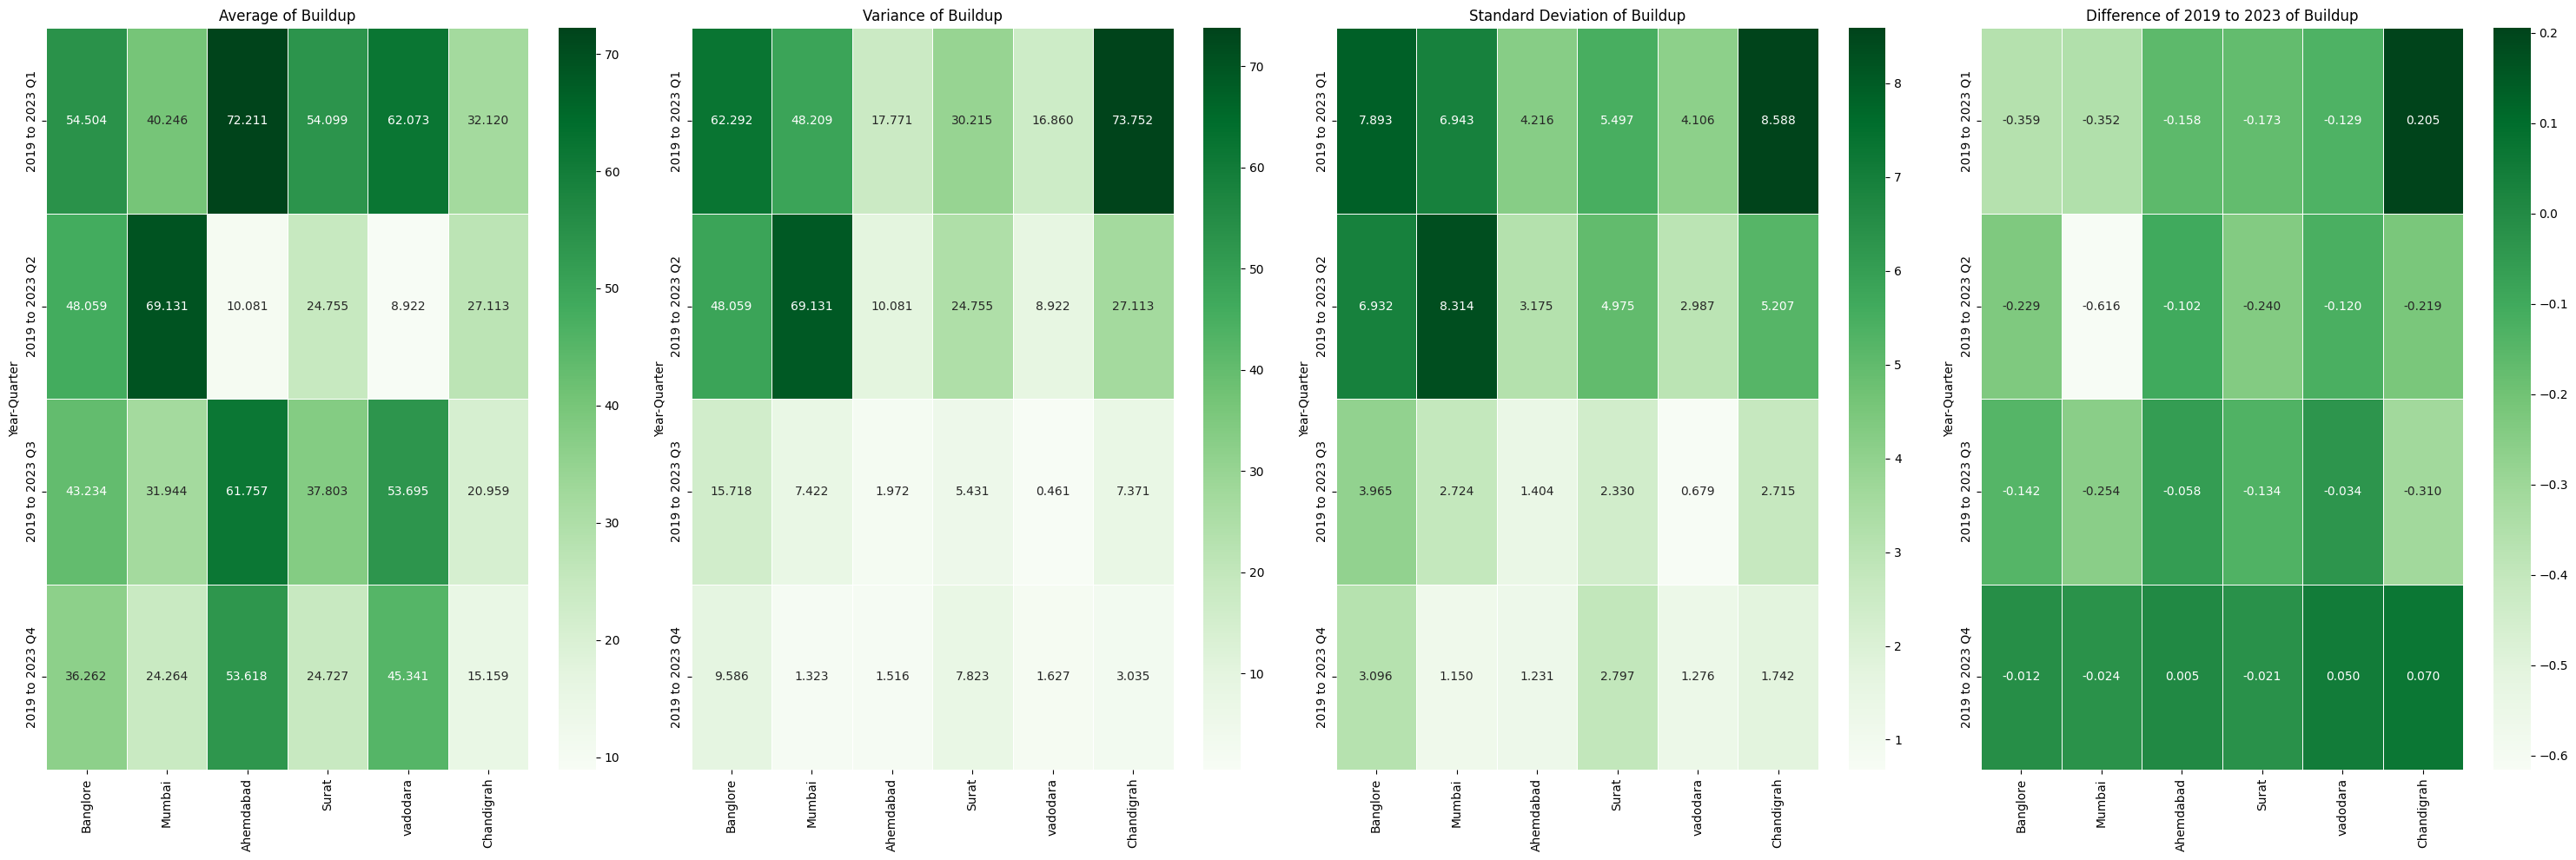

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Read data from Excel files
file_paths = [
    '/content/AV-Buildup Percentage.xlsx',
    '/content/V-Buildup Percentage.xlsx',
    '/content/STD-Buildup Percentage.xlsx',
    '/content/Build up.xlsx'
]

# Define names for each heatmap
heatmap_names = [
    'Average of Buildup',
    'Variance of Buildup',
    'Standard Deviation of Buildup',
    'Difference of 2019 to 2023 of Buildup'
]

# Read data and find the range of years and quarters
quarters = []
for file_path in file_paths:
    df = pd.read_excel(file_path)
    quarters.extend(df.index)

# Sort and get unique quarters
quarters = sorted(set(quarters))

dfs = [pd.read_excel(file_path) for file_path in file_paths]

# Define a function to format the y-axis ticks
def format_yticks(quarters):
    formatted_ticks = []
    for q in quarters:
        year, quarter = divmod(q, 4)
        formatted_ticks.append(f'{2019 + year} to {2019 + year + 4} Q{quarter + 1}')
    return formatted_ticks

# Create subplots for each file
fig, axes = plt.subplots(nrows=1, ncols=len(dfs), figsize=(30,10))



# Plot heatmap for each file
for i, (df, name) in enumerate(zip(dfs, heatmap_names)):
    sns.heatmap(df[['Banglore', 'Mumbai', 'Ahemdabad', 'Surat', 'vadodara', 'Chandigrah']], cmap='Greens', annot=True, cbar=True, fmt=".3f", linewidths=0.5, ax=axes[i])
    axes[i].set_title(name)  # Set title based on the names list
    axes[i].set_ylabel('Year-Quarter')
    axes[i].set_yticklabels(format_yticks(quarters))  # Set formatted Y-axis ticks

# Adjust layout
plt.tight_layout()
plt.show()


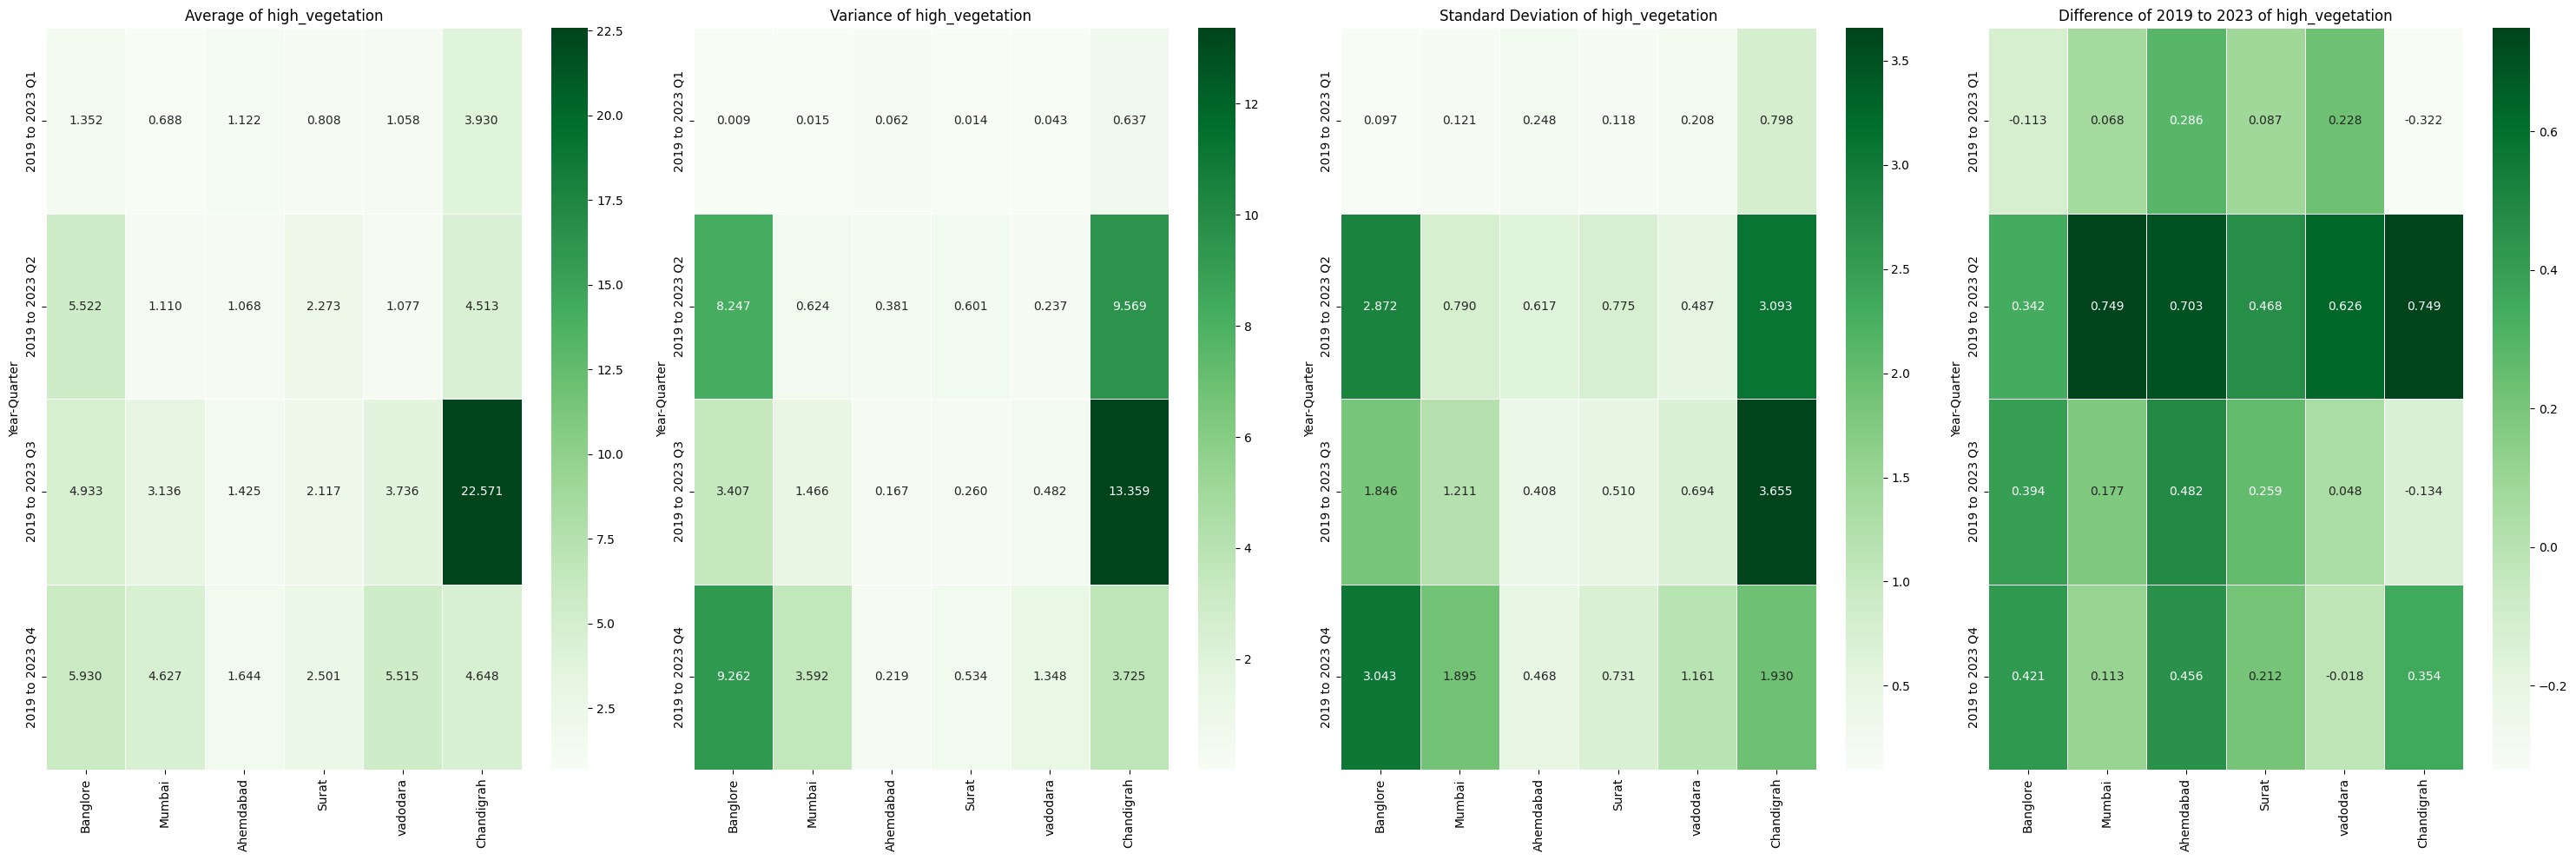

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Read data from Excel files
file_paths = [
    '/content/AV-high_vegetation Percentage.xlsx',
    '/content/V-high_vegetation Percentage.xlsx',
    '/content/STD-high_vegetation Percentage.xlsx',
    '/content/high vegetation.xlsx'
]

# Define names for each heatmap
heatmap_names = [
    'Average of high_vegetation',
    'Variance of high_vegetation',
    'Standard Deviation of high_vegetation',
    'Difference of 2019 to 2023 of high_vegetation'
]

# Read data and find the range of years and quarters
quarters = []
for file_path in file_paths:
    df = pd.read_excel(file_path)
    quarters.extend(df.index)

# Sort and get unique quarters
quarters = sorted(set(quarters))

dfs = [pd.read_excel(file_path) for file_path in file_paths]

# Define a function to format the y-axis ticks
def format_yticks(quarters):
    formatted_ticks = []
    for q in quarters:
        year, quarter = divmod(q, 4)
        formatted_ticks.append(f'{2019 + year} to {2019 + year + 4} Q{quarter + 1}')
    return formatted_ticks

# Create subplots for each file
fig, axes = plt.subplots(nrows=1, ncols=len(dfs), figsize=(30,10))


# Plot heatmap for each file
for i, (df, name) in enumerate(zip(dfs, heatmap_names)):
    sns.heatmap(df[['Banglore', 'Mumbai', 'Ahemdabad', 'Surat', 'vadodara', 'Chandigrah']], cmap='Greens', annot=True, cbar=True, fmt=".3f", linewidths=0.5, ax=axes[i])
    axes[i].set_title(name)  # Set title based on the names list
    axes[i].set_ylabel('Year-Quarter')
    axes[i].set_yticklabels(format_yticks(quarters))  # Set formatted Y-axis ticks

# Adjust layout
plt.tight_layout()
plt.show()


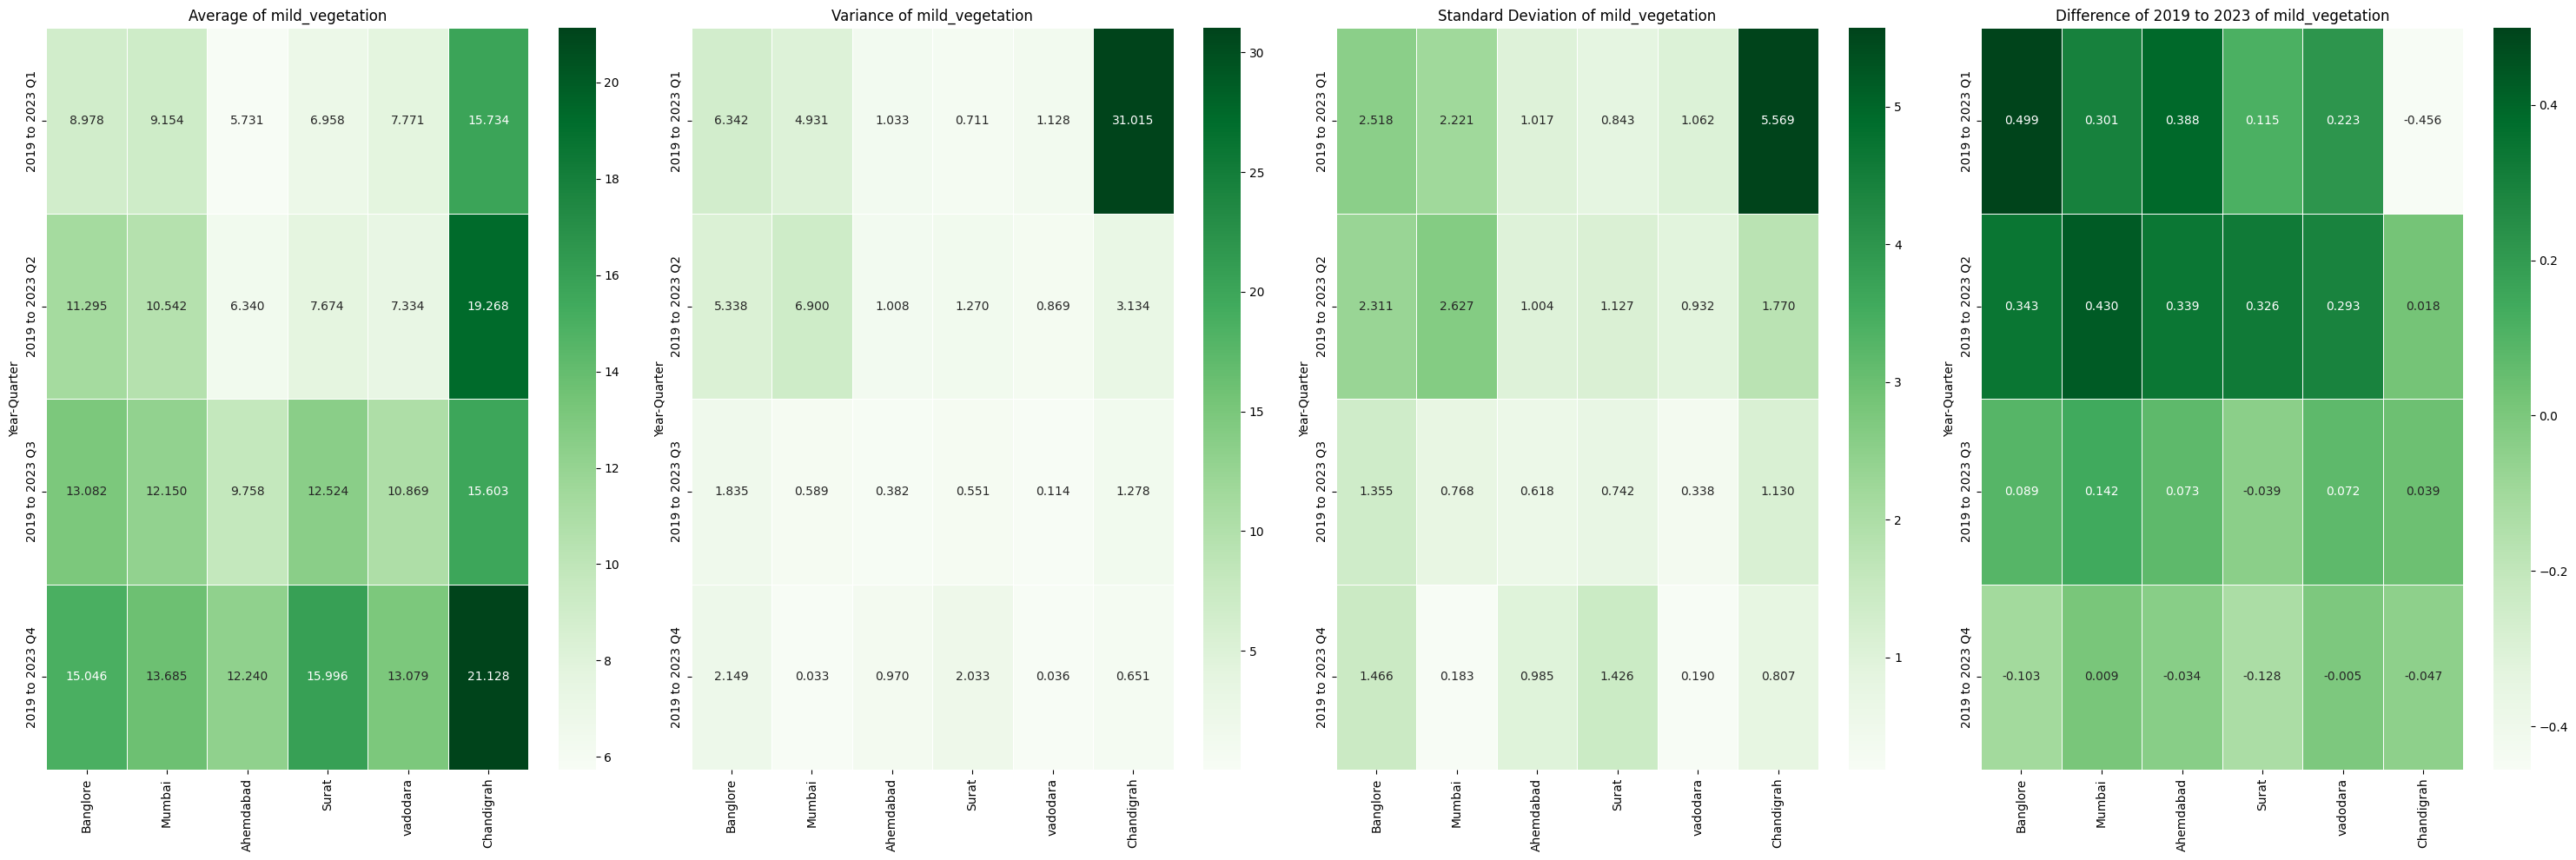

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Read data from Excel files
file_paths = [
    '/content/AV-mild_vegetation Percentage.xlsx',
    '/content/V-mild_vegetation Percentage.xlsx',
    '/content/STD-mild_vegetation Percentage.xlsx',
    '/content/mild vegetation.xlsx'
]

# Define names for each heatmap
heatmap_names = [
    'Average of mild_vegetation',
    'Variance of mild_vegetation',
    'Standard Deviation of mild_vegetation',
    'Difference of 2019 to 2023 of mild_vegetation'
]

# Read data and find the range of years and quarters
quarters = []
for file_path in file_paths:
    df = pd.read_excel(file_path)
    quarters.extend(df.index)

# Sort and get unique quarters
quarters = sorted(set(quarters))

dfs = [pd.read_excel(file_path) for file_path in file_paths]

# Define a function to format the y-axis ticks
def format_yticks(quarters):
    formatted_ticks = []
    for q in quarters:
        year, quarter = divmod(q, 4)
        formatted_ticks.append(f'{2019 + year} to {2019 + year + 4} Q{quarter + 1}')
    return formatted_ticks

# Create subplots for each file
fig, axes = plt.subplots(nrows=1, ncols=len(dfs), figsize=(30,10))


# Plot heatmap for each file
for i, (df, name) in enumerate(zip(dfs, heatmap_names)):
    sns.heatmap(df[['Banglore', 'Mumbai', 'Ahemdabad', 'Surat', 'vadodara', 'Chandigrah']], cmap='Greens', annot=True, cbar=True, fmt=".3f", linewidths=0.5, ax=axes[i])
    axes[i].set_title(name)  # Set title based on the names list
    axes[i].set_ylabel('Year-Quarter')
    axes[i].set_yticklabels(format_yticks(quarters))  # Set formatted Y-axis ticks

# Adjust layout
plt.tight_layout()
plt.show()


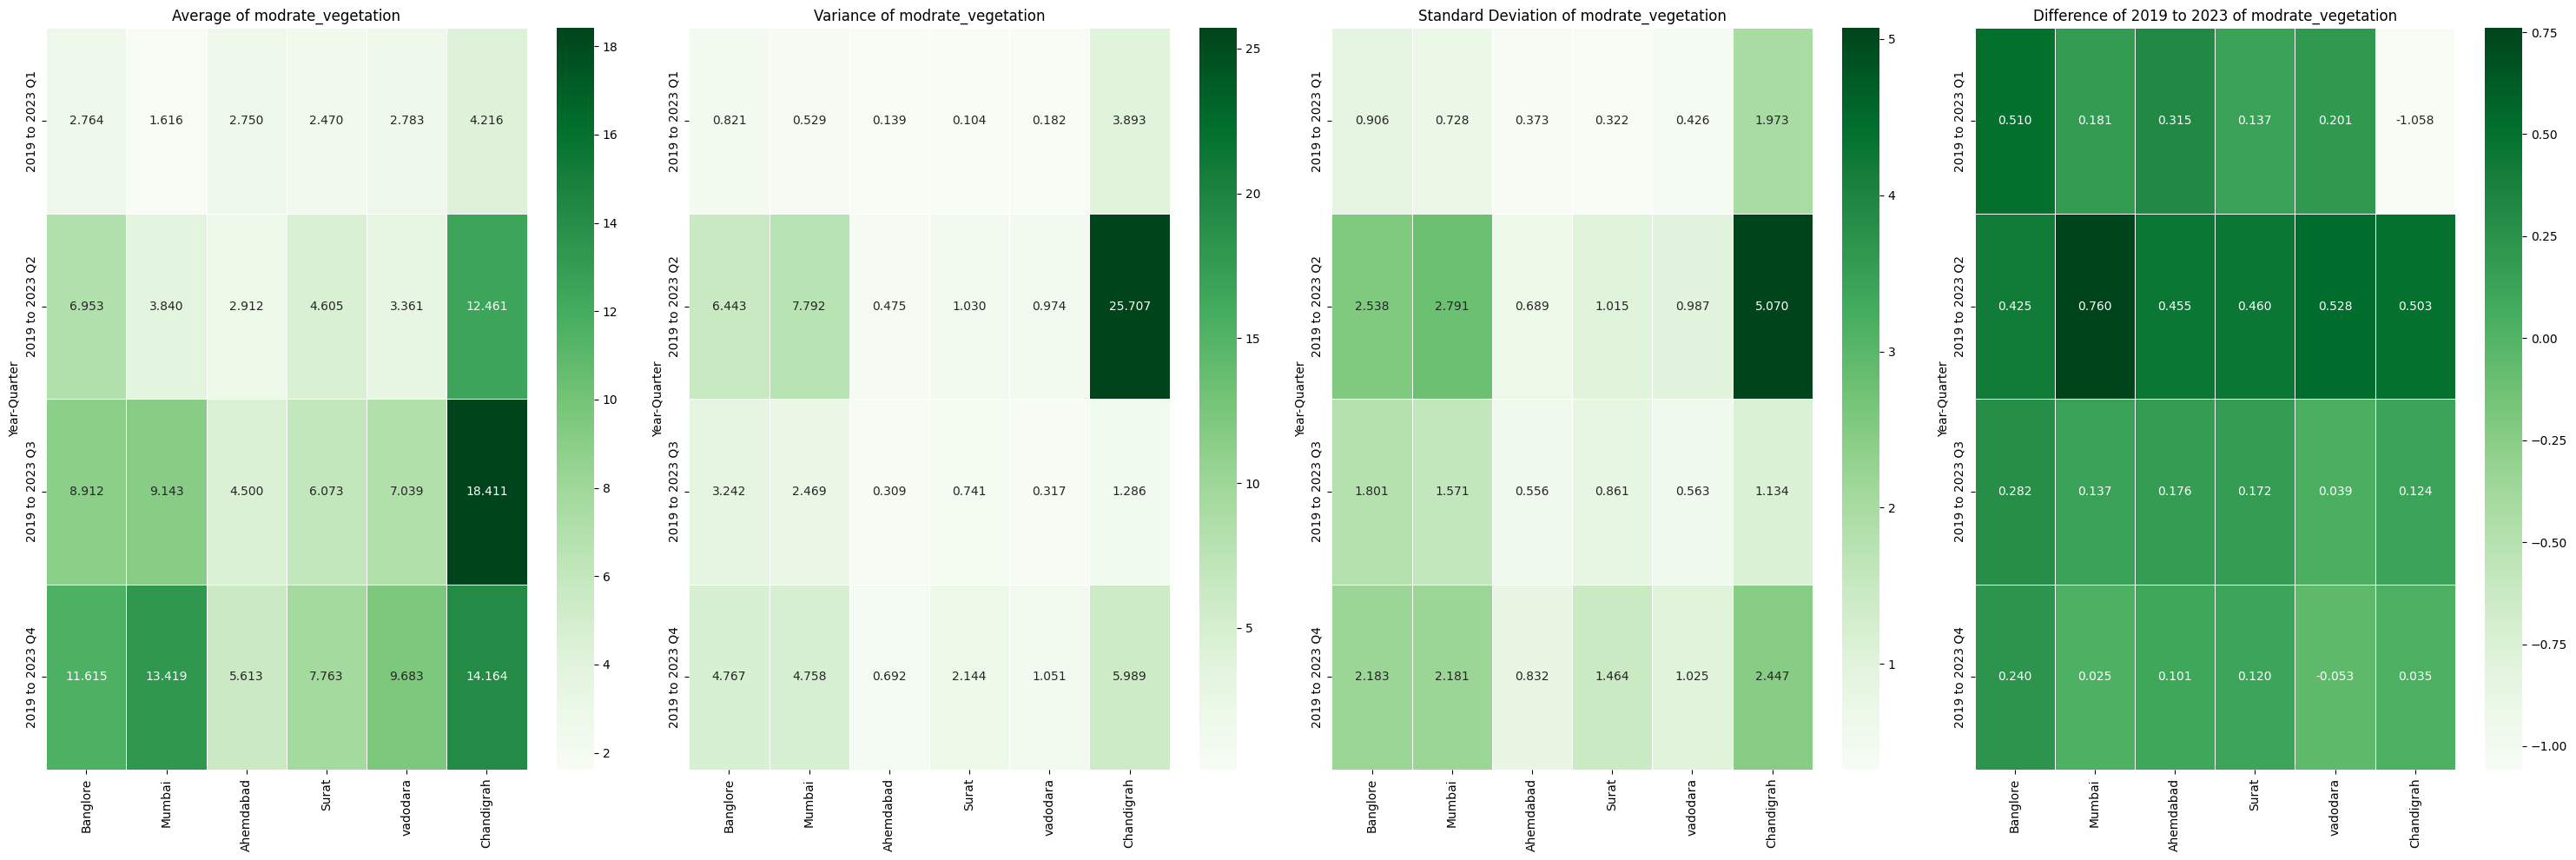

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Read data from Excel files
file_paths = [
    '/content/AV-modrate_vegetation Percentage.xlsx',
    '/content/V-modrate_vegetation Percentage.xlsx',
    '/content/STD-modrate_vegetation Percentage.xlsx',
    '/content/modrate vegetation.xlsx'
]

# Define names for each heatmap
heatmap_names = [
    'Average of modrate_vegetation',
    'Variance of modrate_vegetation',
    'Standard Deviation of modrate_vegetation',
    'Difference of 2019 to 2023 of modrate_vegetation'
]

# Read data and find the range of years and quarters
quarters = []
for file_path in file_paths:
    df = pd.read_excel(file_path)
    quarters.extend(df.index)

# Sort and get unique quarters
quarters = sorted(set(quarters))

dfs = [pd.read_excel(file_path) for file_path in file_paths]

# Define a function to format the y-axis ticks
def format_yticks(quarters):
    formatted_ticks = []
    for q in quarters:
        year, quarter = divmod(q, 4)
        formatted_ticks.append(f'{2019 + year} to {2019 + year + 4} Q{quarter + 1}')
    return formatted_ticks

# Create subplots for each file
fig, axes = plt.subplots(nrows=1, ncols=len(dfs), figsize=(30,10))


# Plot heatmap for each file
for i, (df, name) in enumerate(zip(dfs, heatmap_names)):
    sns.heatmap(df[['Banglore', 'Mumbai', 'Ahemdabad', 'Surat', 'vadodara', 'Chandigrah']], cmap='Greens', annot=True, cbar=True, fmt=".3f", linewidths=0.5, ax=axes[i])
    axes[i].set_title(name)  # Set title based on the names list
    axes[i].set_ylabel('Year-Quarter')
    axes[i].set_yticklabels(format_yticks(quarters))  # Set formatted Y-axis ticks

# Adjust layout
plt.tight_layout()
plt.show()


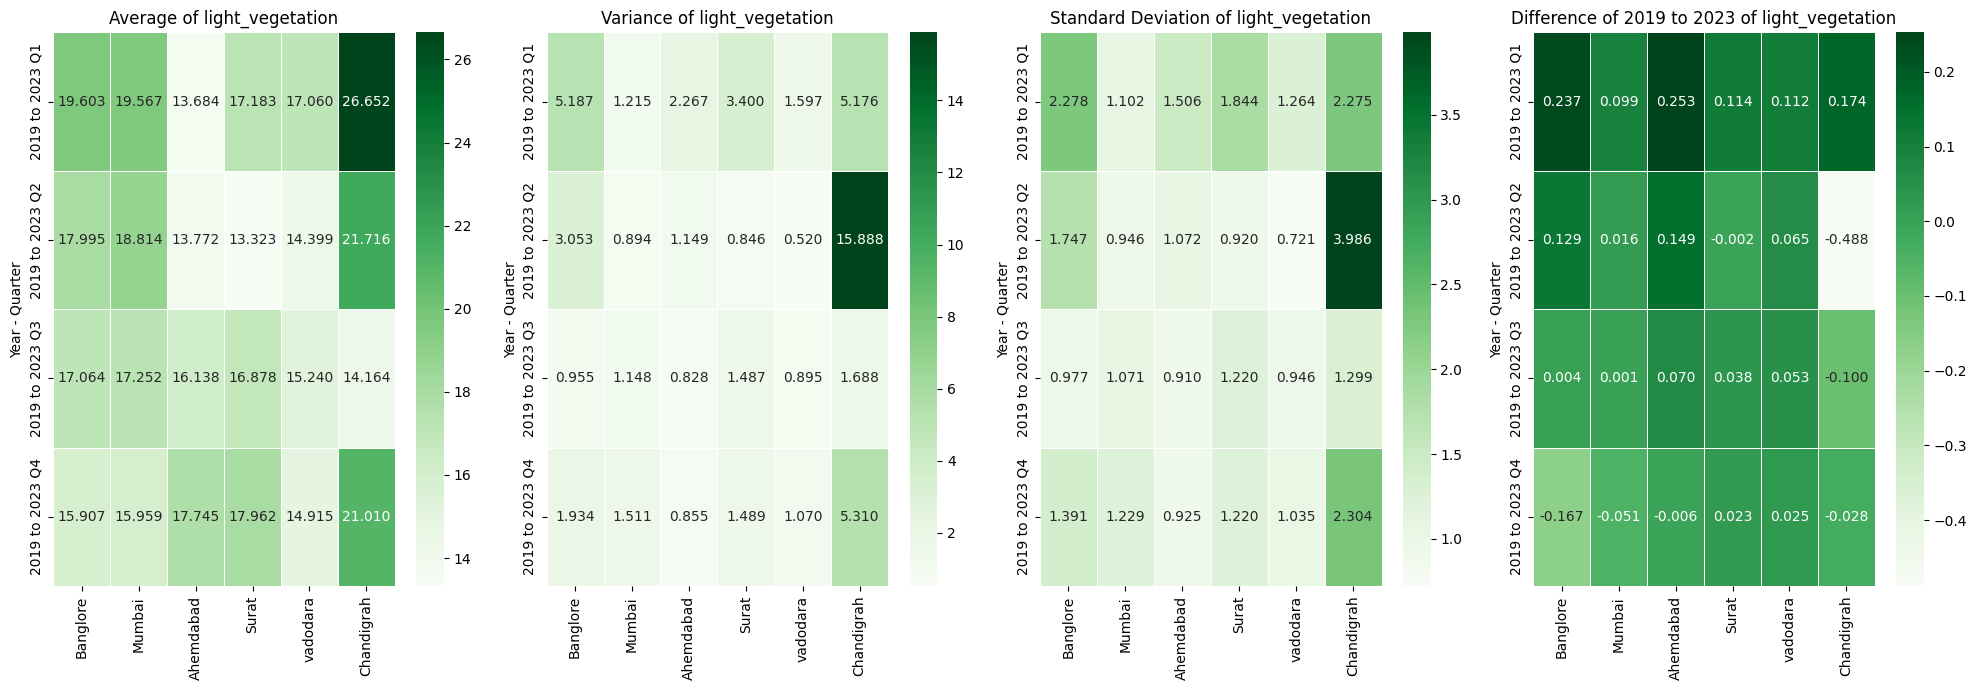

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Read data from Excel files
file_paths = [
    '/content/AV-light_vegetation Percentage.xlsx',
    '/content/V-light_vegetation Percentage.xlsx',
    '/content/STD-light_vegetation Percentage.xlsx',
    '/content/light vegetation.xlsx'
]

# Define names for each heatmap
heatmap_names = [
    'Average of light_vegetation',
    'Variance of light_vegetation',
    'Standard Deviation of light_vegetation',
    'Difference of 2019 to 2023 of light_vegetation'
]

# Read data and find the range of years and quarters
quarters = []
for file_path in file_paths:
    df = pd.read_excel(file_path)
    quarters.extend(df.index)

# Sort and get unique quarters
quarters = sorted(set(quarters))

dfs = [pd.read_excel(file_path) for file_path in file_paths]

# Define a function to format the y-axis ticks
def format_yticks(quarters):
    formatted_ticks = []
    for q in quarters:
        year, quarter = divmod(q, 4)
        formatted_ticks.append(f'{2019 + year } to {2019 + year + 4} Q{quarter + 1}')
    return formatted_ticks

# Create subplots for each file
fig, axes = plt.subplots(nrows=1, ncols=len(dfs), figsize=(20, 7))

# Plot heatmap for each file
for i, (df, name) in enumerate(zip(dfs, heatmap_names)):
    sns.heatmap(df[['Banglore', 'Mumbai', 'Ahemdabad', 'Surat', 'vadodara', 'Chandigrah']], cmap='Greens', annot=True, cbar=True, fmt=".3f", linewidths=0.5, ax=axes[i])
    axes[i].set_title(name)  # Set title based on the names list
    axes[i].set_ylabel('Year - Quarter')
    axes[i].set_yticklabels(format_yticks(quarters))  # Set formatted Y-axis ticks

# Adjust layout
plt.tight_layout()
plt.show()
